## Imports


In [76]:
import pandas as pd
import numpy as np

## Loading Dataset


In [77]:
# i want to put a json object in a pandas dataframe
df_1 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/AO_Output.json"
)
df_2 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/FA Output.json"
)
df_3 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/video_4_annotated.json"
)
df_4 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/integrated_data.json"
)
df_5 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/nadines_video_annotated.json"
)
df_6 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/video_1_annotated.json"
)

In [78]:
# add an index column to each dataframe
df_1["index"] = 1
df_2["index"] = 2
df_3["index"] = 3
df_4["index"] = 4
df_5["index"] = 5
df_6["index"] = 6

In [79]:
dfs = [df_1, df_2, df_3, df_4, df_5, df_6]
for idx, df in enumerate(dfs, 1):
    print(f"df_{idx} event value counts:")
    print(df["event"].value_counts())
    print("-" * 40)

df_1 event value counts:
event
backhand    112
forehand     68
Name: count, dtype: int64
----------------------------------------
df_2 event value counts:
event
backhand    113
forehand     61
Name: count, dtype: int64
----------------------------------------
df_3 event value counts:
event
backhand    50
forehand    26
Name: count, dtype: int64
----------------------------------------
df_4 event value counts:
event
backhand    12
forehand     5
Name: count, dtype: int64
----------------------------------------
df_5 event value counts:
event
backhand    17
forehand    14
Name: count, dtype: int64
----------------------------------------
df_6 event value counts:
event
backhand    49
forehand    29
Name: count, dtype: int64
----------------------------------------


In [80]:
train_df = pd.concat([df_1, df_2, df_5, df_4, df_6], ignore_index=True)
test_df = df_3.copy()

In [81]:
train_df.shape

(31499, 6)

In [82]:
train_df["event"].value_counts()

event
backhand    303
forehand    177
Name: count, dtype: int64

In [83]:
test_df.shape

(9988, 6)

In [84]:
test_df["event"].value_counts()

event
backhand    50
forehand    26
Name: count, dtype: int64

In [85]:
def expand_df(df):
    expanded_df = (
        df["keypoints"]
        .apply(
            lambda person: {f"x_{part}": person[part]["x"] for part in person}
            | {f"y_{part}": person[part]["y"] for part in person}
        )
        .apply(pd.Series)
    )

    # Merge back into original df if needed
    df_expanded = pd.concat([df, expanded_df], axis=1)

    # Optionally drop original nested column
    df_expanded.drop(columns=["keypoints"], inplace=True)
    return df_expanded


train_df_expanded = expand_df(train_df)
test_df_expanded = expand_df(test_df)

In [86]:
train_df_expanded.shape

(31499, 29)

In [87]:
def add_sequence(df_expanded):
    event_indices = df_expanded[df_expanded["event"].notnull()].index

    selected_indices = set()
    neither_count = 0
    MAX_NEITHER_SEGMENTS = 250

    # Step 1: Annotate labeled events and their 15-frame tails
    for idx in event_indices:
        label = df_expanded.at[idx, "event"]
        group_id = df_expanded.at[idx, "index"]
        selected_indices.add(idx)
        df_expanded.at[idx, "event"] = label

        for offset in range(1, 16):
            next_idx = idx + offset
            if next_idx >= len(df_expanded):
                break

            if (
                pd.notnull(df_expanded.at[next_idx, "event"])
                or df_expanded.at[next_idx, "index"] != group_id
            ):
                break

            selected_indices.add(next_idx)
            df_expanded.at[next_idx, "event"] = label

    # Step 2: Annotate null event segments in 16-frame "neither" batches
    null_indices = df_expanded[df_expanded["event"].isnull()].index
    null_indices = sorted(null_indices)

    i = 0
    while i < len(null_indices):
        if neither_count >= MAX_NEITHER_SEGMENTS:
            break

        start_idx = null_indices[i]
        group_id = df_expanded.at[start_idx, "index"]

        # Collect consecutive nulls in same group
        segment = [start_idx]
        for j in range(i + 1, len(null_indices)):
            current_idx = null_indices[j]
            prev_idx = null_indices[j - 1]

            if (
                current_idx == prev_idx + 1
                and df_expanded.at[current_idx, "index"] == group_id
            ):
                segment.append(current_idx)
            else:
                break

        # Process in batches of 16
        for k in range(0, len(segment), 16):
            if neither_count >= MAX_NEITHER_SEGMENTS:
                break

            batch = segment[k : k + 16]
            if len(batch) == 16:
                for idx in batch:
                    selected_indices.add(idx)
                    df_expanded.at[idx, "event"] = "neither"
                neither_count += 1

        i += len(segment)

    # Step 3: Final filtering
    df_expanded = df_expanded.loc[sorted(selected_indices)].reset_index(drop=True)

    print(f"Number of 'neither' segments (16-frame batches): {neither_count}")

    return df_expanded


train_df_expanded = add_sequence(train_df_expanded)
test_df_expanded = add_sequence(test_df_expanded)

Number of 'neither' segments (16-frame batches): 250
Number of 'neither' segments (16-frame batches): 250


In [88]:
train_df_expanded["event"].value_counts()

event
backhand    4737
neither     4000
forehand    2778
Name: count, dtype: int64

In [89]:
test_df_expanded["event"].value_counts()

event
neither     4000
backhand     785
forehand     401
Name: count, dtype: int64

## Better Approach (LSTM - 30 Frames per event)


In [90]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [91]:
lstm_df = pd.read_csv(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/combined_data.csv"
)

In [92]:
# ----------------------------
# Step 1: Normalize coordinates
# ----------------------------
coord_cols = [
    col
    for col in train_df_expanded.columns
    if col.startswith("x") or col.startswith("y")
]
scaler = MinMaxScaler()
train_df_expanded[coord_cols] = scaler.fit_transform(train_df_expanded[coord_cols])

In [93]:
train_df_expanded.drop(columns=["player_id", "time", "index"], inplace=True)

In [94]:
# Step 2: Label encoding
# ----------------------------
label_map = {"forehand": 0, "backhand": 1, "neither": 2}
train_df_expanded = train_df_expanded[
    train_df_expanded["event"].isin(label_map.keys())
].copy()
train_df_expanded["event"] = train_df_expanded["event"].map(label_map).astype(int)

In [95]:
# ----------------------------
# Step 1: Normalize coordinates
# ----------------------------
coord_cols = [
    col
    for col in test_df_expanded.columns
    if col.startswith("x") or col.startswith("y")
]
scaler = MinMaxScaler()
test_df_expanded[coord_cols] = scaler.fit_transform(test_df_expanded[coord_cols])

In [96]:
test_df_expanded.drop(columns=["player_id", "time", "index"], inplace=True)

In [97]:
# Step 2: Label encoding
# ----------------------------
label_map = {"forehand": 0, "backhand": 1, "neither": 2}
test_df_expanded = test_df_expanded[
    test_df_expanded["event"].isin(label_map.keys())
].copy()
test_df_expanded["event"] = test_df_expanded["event"].map(label_map).astype(int)

In [98]:
# Data preparation with non-overlapping windows
X_train = []
y_train = []
window_size = 16

# Process the data in non-overlapping chunks of size 16
for i in range(0, len(train_df_expanded), window_size):
    # Check if we have a full window
    if i + window_size <= len(train_df_expanded):
        window = train_df_expanded.iloc[i : i + window_size]

        # Only use the window if all rows have the same event
        if window["event"].nunique() == 1:
            X_train.append(
                window[coord_cols].values
            )  # Shape: (16, 24) - 16 timesteps, 24 features
            # Store the single event for this window
            y_train.append(window["event"].iloc[0])

X_train = np.array(X_train)  # shape should be (num_non_overlapping_windows, 16, 24)
y_train = np.array(y_train)  # shape should be (num_non_overlapping_windows,)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Label distribution: {np.unique(y_train, return_counts=True)}")

X_train shape: (515, 16, 24)
y_train shape: (515,)
Label distribution: (array([0, 1, 2]), array([ 94, 214, 207]))


In [99]:
# Data preparation with non-overlapping windows
X_test = []
y_test = []
window_size = 16

# Process the data in non-overlapping chunks of size 16
for i in range(0, len(test_df_expanded), window_size):
    # Check if we have a full window
    if i + window_size <= len(test_df_expanded):
        window = test_df_expanded.iloc[i : i + window_size]

        # Only use the window if all rows have the same event
        if window["event"].nunique() == 1:
            X_test.append(
                window[coord_cols].values
            )  # Shape: (16, 24) - 16 timesteps, 24 features
            # Store the single event for this window
            y_test.append(window["event"].iloc[0])

X_test = np.array(X_test)  # shape should be (num_non_overlapping_windows, 16, 24)
y_test = np.array(y_test)  # shape should be (num_non_overlapping_windows,)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Label distribution: {np.unique(y_test, return_counts=True)}")

X_test shape: (294, 16, 24)
y_test shape: (294,)
Label distribution: (array([0, 1, 2]), array([ 19,  34, 241]))


In [100]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

In [101]:
model = Sequential()
# Input shape: (16 timesteps, 24 features)
model.add(LSTM(4, input_shape=(window_size, len(coord_cols)), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(3, activation="softmax"))  # 3 classes (0, 1, 2)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

/home/g03-s2025/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [102]:
# ----------------------------
# Step 6: Training
# ----------------------------
# Early stopping
# early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,  # You can adjust this batch size for training
    # callbacks=[early_stop],
    verbose=1,
)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4066 - loss: 1.1050 - val_accuracy: 0.2109 - val_loss: 1.1523
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7080 - loss: 0.9884 - val_accuracy: 0.2993 - val_loss: 1.2837
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6994 - loss: 0.7894 - val_accuracy: 0.1497 - val_loss: 1.5721
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6901 - loss: 0.7261 - val_accuracy: 0.1259 - val_loss: 1.7749
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7479 - loss: 0.6639 - val_accuracy: 0.1293 - val_loss: 1.8114
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6675 - loss: 0.7181 - val_accuracy: 0.3163 - val_loss: 1.4177
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7308 - loss: 0.6045 - val_accuracy: 0.3231 - val_loss: 1.5655
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7662 - loss: 0.5778 - val_accuracy: 0.1735 - v

In [104]:
# print classification report


# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=1)
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.14      1.00      0.24        19
           1       0.17      0.76      0.27        34
           2       0.00      0.00      0.00       241

    accuracy                           0.15       294
   macro avg       0.10      0.59      0.17       294
weighted avg       0.03      0.15      0.05       294



/home/g03-s2025/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/g03-s2025/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/g03-s2025/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


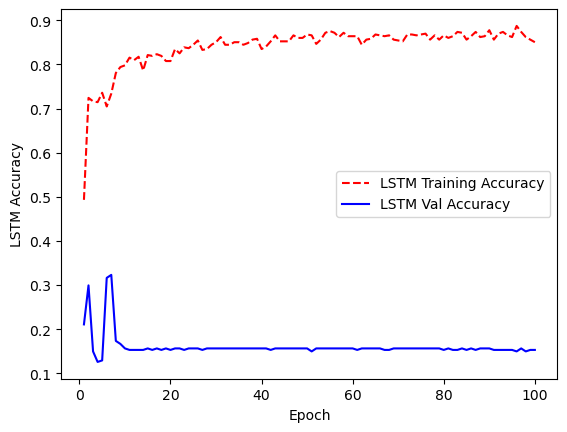

In [105]:
# Get training and validation accuracy histories
import matplotlib.pyplot as plt

training_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

EPOCHS = len(training_acc)

# Create count of the number of epochs
epoch_count = range(1, EPOCHS + 1)

# Visualize accuracy history
plt.figure()
plt.plot(epoch_count, training_acc, "r--")
plt.plot(epoch_count, val_acc, "b-")
plt.legend(["LSTM Training Accuracy", "LSTM Val Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("LSTM Accuracy")
plt.show()

In [106]:
train_df_expanded[coord_cols].values

array([[0.04464497, 0.06950206, 0.17008873, ..., 0.36280075, 0.3962371 ,
        0.38940375],
       [0.04679465, 0.06951466, 0.17190237, ..., 0.36331173, 0.39627147,
        0.38968523],
       [0.05054047, 0.07301442, 0.18018128, ..., 0.36014757, 0.39189207,
        0.38652441],
       ...,
       [0.7129587 , 0.73332434, 0.73432069, ..., 0.6559937 , 0.70998196,
        0.71219754],
       [0.72310877, 0.71931471, 0.74789588, ..., 0.65862737, 0.71740155,
        0.71352743],
       [0.72159775, 0.7178542 , 0.74767949, ..., 0.6607519 , 0.71864904,
        0.71493674]])

In [107]:
X = train_df_expanded.drop(columns=["event"])
y = train_df_expanded["event"]

test_x = test_df_expanded.drop(columns=["event"])
test_y = test_df_expanded["event"]

In [108]:
# import xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X, y)
y_pred = xgb.predict(test_x)
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.16      0.99      0.28       401
           1       0.22      0.75      0.34       785
           2       0.00      0.00      0.00      4000

    accuracy                           0.19      5186
   macro avg       0.13      0.58      0.20      5186
weighted avg       0.05      0.19      0.07      5186

